In [4]:
from mindspore import ops
from mindspore.common import dtype as mstype
import mindspore as ms
from mindspore import nn
from mindspore.nn import LossBase
from mindspore import context


In [13]:
import numpy as np
from glob import glob
import os
import nibabel as nib
import cv2
from matplotlib import pyplot as PLT
from ipywidgets import interact,interactive, IntSlider, ToggleButtons

from scipy import sparse
from tqdm import tqdm
import SimpleITK as sitk




In [5]:
def GetBodyArea(ct, padding=5):
    cs, ch, cw = ct.shape
    src = np.zeros([3, ch, cw])
    src[0, :, :] = ct[cs // 4 * 1, :, :]
    src[1, :, :] = ct[cs // 4 * 2, :, :]
    src[2:, :] = ct[cs // 4 * 3, :, :]
    src = src.max(axis=0)
    src = (src - src.min()) * 255 / (src.max() - src.min())
    src = np.uint8(src)

    _, src = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    src = cv2.morphologyEx(src, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    cnts, hu = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return 0, 0, cw, ch
    max_area = 0
    max_cnt = cnts[0]
    for c in cnts:
        area = cv2.contourArea(c)
        if max_area < area:
            max_area = area
            max_cnt = c
    if max_area < cw * ch / 4:
        return 0, 0, cw, ch
    x, y, w, h = cv2.boundingRect(max_cnt)
    w = w + padding if x + w + padding < cw else cw - x
    h = h + padding if x + h + padding < ch else ch - x
    x = x - padding if x > padding else 0
    y = y - padding if y > padding else 0

    return x, y, w, h



def cvresize(src, size,interpolation=cv2.INTER_CUBIC):
    minc = min(size)
    s = src.shape[-1] // minc
    if s != 0 and src.shape[-1] != minc:
        dst = np.zeros((size[1], size[0], src.shape[-1]))
        for i in range(s + 1):
            if i != s:
                dst[:, :, i * minc : (i + 1) * minc] = cv2.resize(
                    src[:, :, i * minc : (i + 1) * minc], size
                )
            else:
                dst[:, :, i * minc :] = cv2.resize(src[:, :, i * minc :], size)
    else:
        dst = cv2.resize(src, size,interpolation=interpolation)
    return dst


def ReSp(src, x, y, w, h, restore=False, size=512,interpolation=cv2.INTER_CUBIC):
    if restore:
        dst = np.zeros((src.shape[0], size, size), np.float64)
        src = src.transpose((1, 2, 0))
        src = cvresize(src, [w, h],interpolation)
        src = src.transpose((2, 0, 1))
        dst[:, y : y + h, x : x + w] = src
    else:
        dst = src[:, y : y + h, x : x + w]
        dst = dst.transpose((1, 2, 0))
        dst = cvresize(dst, [size, size])
        dst = dst.transpose((2, 0, 1))
    return dst

100%|██████████| 210/210 [32:53<00:00,  9.40s/it]


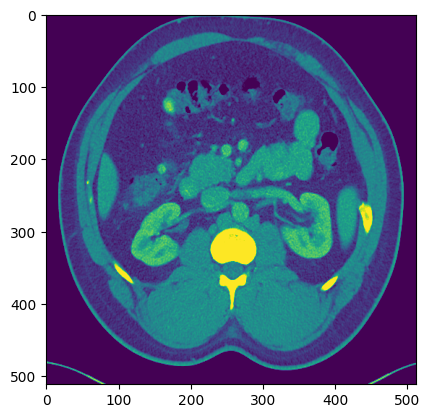

In [8]:
pad = 3
win_centre = 62
win_middle = 482
win_min = win_centre-win_middle/2
win_max = win_centre+win_middle/2


save_path = '/home/cat/lrx/git/kits19/train'
path = '/home/cat/lrx/git/kits19/data'
# cts = glob(os.path.join(path,'case_*/imaging.nii.gz'))
segs = glob(os.path.join(path,'case_*/segmentation.nii.gz'))
segs = sorted(segs)


for seg_path in tqdm(segs):
    ct_path = os.path.join(os.path.dirname(seg_path),'imaging.nii.gz')
    name = ct_path.split('/')[-2]
    ct = nib.load(ct_path).get_fdata()
    seg = nib.load(seg_path).get_fdata().astype(np.uint8)
    assert ct.shape == seg.shape
    x, y, w, h = GetBodyArea(ct)
    ct = ReSp(ct, x, y, w, h)
    seg = ReSp(seg, x, y, w, h,interpolation=cv2.INTER_NEAREST)
    ct[ct<win_min]=win_min
    ct[ct>win_max]=win_max
    # ct = (ct-ct.min()) / (ct.max()-ct.min()) * 1024
    ct_norm = (ct-ct.mean())/ct.std()
    # print(ct_norm.min(),ct_norm.max())
    # ct = ct_norm - ct_norm.min() - 1/ct.std()
    ct = ct_norm - ct_norm.min()
    # ct[ct<0]=5
    # PLT.imshow(ct[300])
    # PLT.imshow(seg[300])
    # break
    ct = np.float32(ct)
    seg = np.uint8(seg)
    z = np.any(seg,axis=(1, 2))
    z = np.where(z)[0]
    begin = max(pad+1, z[0])
    end = min(seg.shape[0]-pad, z[-1])
    ct = ct[begin:end,:,:]
    seg = seg[begin:end,:,:]
    # if ct.std(axis=(1,2)).std()>25:
    #     continue

    try:
        os.makedirs(os.path.join(save_path,name))
    except:
        pass
    ctshow=ct
    ctshow[ctshow<0] = 3
    PLT.imshow(ctshow[ctshow.shape[0]//2])
    PLT.savefig(os.path.join(save_path,'img',name+'.jpg'))
    np.save(os.path.join(save_path,name,'ct.npy'), ct)
    seg_sp = np.array([sparse.csc_matrix(seg[i,:,:]) for i in range(seg.shape[0])])
    np.save(os.path.join(save_path,name,'seg.npy'), seg_sp)

# np.load('case_00115_seg.npy')

In [39]:
from mindspore import nn, Tensor
from mindspore.common import dtype as mstype
from mindspore import context
import numpy as np
from mindspore import ops as P
context.set_context(mode=context.PYNATIVE_MODE, device_target='CPU')

class MSSSIMLoss(nn.LossBase):
    def __init__(self, ignore_indiex=None):
        super().__init__()
        self.msssim = nn.MSSSIM(max_val=1.0, k1=0.01**2, k2=0.03**2)
        # self.msssim.set_grad(False)
        self.mean = P.ReduceMean()
        self.ignore_indiex = ignore_indiex

    def construct(self, logits, labels):
        if self.ignore_indiex is None:
            ssim_logits = logits
            ssim_labels = labels
        elif self.ignore_indiex == 0:
            ssim_logits = logits[:, 1:, ...]
            ssim_labels = labels[:, 1:, ...]
        elif self.ignore_indiex == P.Shape(logits)[1] - 1:
            ssim_logits = logits[:, :-1, ...]
            ssim_labels = labels[:, :-1, ...]
        else:
            ssim_logits = P.concat(
                (
                    logits[:, 0 : self.ignore_indiex, ...],
                    logits[:, self.ignore_indiex + 1 :, ...],
                )
            )
            ssim_labels = P.concat(
                (
                    labels[:, 0 : self.ignore_indiex, ...],
                    labels[:, self.ignore_indiex + 1 :, ...],
                )
            )
        loss = self.msssim(ssim_logits, ssim_labels)
        loss = 1 - self.mean(loss)
        return loss

loss = nn.DiceLoss(smooth=1e-5)
loss = MSSSIMLoss()
loss = nn.MSSSIM(max_val=1.0, k1=0.01**2, k2=0.03**2)
a = [0 for i in range(512)]
a = [a for i in range(512)]
a = [[a for i in range(3)]]
a[0][0][0][0] =0
logits = Tensor(np.array(a),dtype=mstype.float32)
labels = Tensor(np.array(a),dtype=mstype.float32)
output = loss(logits, labels)
print(output)

[1.]


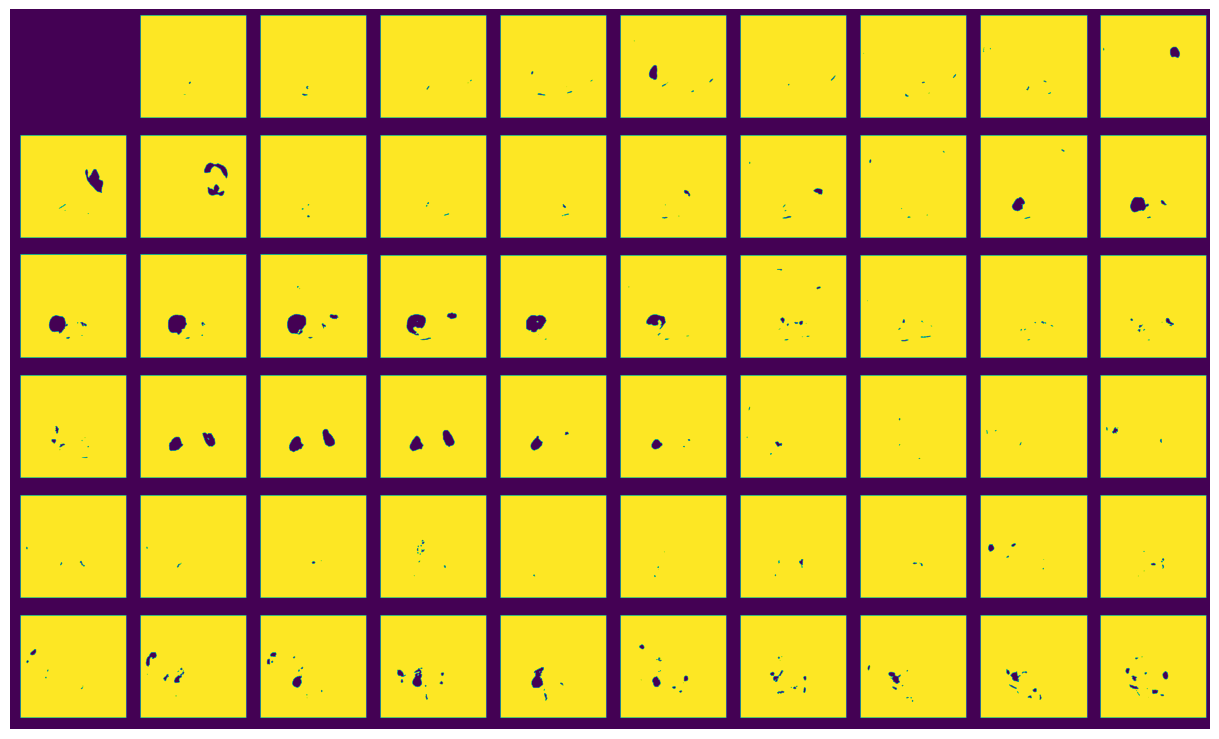

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [52]:
seg = nib.load('/home/cat/lrx/test/case_00297.nii.gz').get_fdata().astype(np.uint8).transpose((1,2,0))
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = PLT.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j])
            axarr[i, j].axis("off")
    PLT.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    PLT.show()

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(6, 10, 512, 512, seg[:, :, :60])
print(seg[:, :, :40])

In [16]:
seg = nib.load('/home/cat/lrx/test/filtercase_00296.nii.gz')
b = seg.get_fdata()[50,:,:]
# seg = nib.load('/home/cat/lrx/git/kits19/data/case_00001/segmentation.nii.gz')
# a = seg.get_fdata()[346,:,:]
def plot3d(img, seg = None):
    def imshow(layer):
        fig_img, ax_img = PLT.subplots()
        ax_img.imshow(img.get_fdata()[layer,:,:])
        if seg:
            fig_seg, ax_seg =  PLT.subplots()
            ax_seg.imshow(seg.get_fdata()[layer,:,:])
    
    interact(imshow, layer=(0,img.get_fdata().shape[0]-1))
    
plot3d(seg)

interactive(children=(IntSlider(value=41, description='layer', max=82), Output()), _dom_classes=('widget-inter…

In [ ]:
cts = glob(os.path.join(path,'case_2[1-9][0-9]/segmentation.nii.gz'))
cts = sorted(cts)
save_path = '/home/cat/lrx/git/kits19/test'



for ct_path in tqdm(cts):
    name = seg_path.split('/')[-2]
    ct = nib.load(ct_path).get_fdata()
    x, y, w, h = GetBodyArea(ct)
    ct = ReSp(ct, x, y, w, h)
    ct[ct<win_min]=win_min
    ct[ct>win_max]=win_max
    # ct = (ct-ct.min()) / (ct.max()-ct.min()) * 1024
    ct_norm = (ct-ct.mean())/ct.std()
    # print(ct_norm.min(),ct_norm.max())
    # ct = ct_norm - ct_norm.min() - 1/ct.std()
    ct = ct_norm - ct_norm.min()
    # ct[ct<0]=5
    # PLT.imshow(ct[300])
    # PLT.imshow(seg[300])
    # break
    ct = np.float32(ct)
    seg = np.uint8(seg)
    z = np.any(seg,axis=(1, 2))
    z = np.where(z)[0]
    begin = max(pad+1, z[0])
    end = min(seg.shape[0]-pad, z[-1])
    ct = ct[begin:end,:,:]
    seg = seg[begin:end,:,:]
    # if ct.std(axis=(1,2)).std()>25:
    #     continue

    try:
        os.makedirs(os.path.join(save_path,name))
    except:
        pass
    ctshow=ct
    ctshow[ctshow<0] = 3
    PLT.imshow(ctshow[ctshow.shape[0]//2])
    PLT.savefig(os.path.join(save_path,'img',name+'.jpg'))
    np.save(os.path.join(save_path,name,'ct.npy'), ct)
    seg_sp = np.array([sparse.csc_matrix(seg[i,:,:]) for i in range(seg.shape[0])])
    np.save(os.path.join(save_path,name,'seg.npy'), seg_sp)

In [17]:
def RemoveSmallConnectedCompont(sitk_maskimg, rate=0.5):
    '''
    two steps:
        step 1: Connected Component analysis: 将输入图像分成 N 个连通域
        step 2: 假如第 N 个连通域的体素小于最大连通域 * rate，则被移除
    :param sitk_maskimg: input binary image 使用 sitk.ReadImage(path, sitk.sitkUInt8) 读取，
                        其中sitk.sitkUInt8必须注明，否则使用 sitk.ConnectedComponent 报错
    :param rate: 移除率，默认为0.5， 小于 1/2最大连通域体素的连通域被移除
    :return:  binary image， 移除了小连通域的图像
    '''
 
    # step 1 Connected Component analysis
    cc = sitk.ConnectedComponent(sitk_maskimg)
    stats = sitk.LabelIntensityStatisticsImageFilter()
    stats.Execute(cc, sitk_maskimg)
    maxlabel = 0   # 获取最大连通域的索引
    maxsize = 0    # 获取最大连通域的体素大小
 
    # 遍历每一个连通域， 获取最大连通域的体素大小和索引
    for l in stats.GetLabels():  # stats.GetLabels()  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
        size = stats.GetPhysicalSize(l)   # stats.GetPhysicalSize(5)=75  表示第5个连通域的体素有75个
        if maxsize < size:
            maxlabel = l
            maxsize = size
 
    # step 2 获取每个连通域的大小，保留 size >= maxsize * rate 的连通域
    not_remove = []
    for l in stats.GetLabels():
        size = stats.GetPhysicalSize(l)
        if size >= maxsize * rate:
            not_remove.append(l)
 
    labelmaskimage = sitk.GetArrayFromImage(cc)
    outmask = labelmaskimage.copy()
    outmask[labelmaskimage != maxlabel] = 0
    for i in range(len(not_remove)):
        outmask[labelmaskimage == not_remove[i]] = 1
  # 保存图像
    outmask = outmask.astype('float32')
 
    out = sitk.GetImageFromArray(outmask)
    out.SetDirection(sitk_maskimg.GetDirection())
    out.SetSpacing(sitk_maskimg.GetSpacing())
    out.SetOrigin(sitk_maskimg.GetOrigin())   # 使 out 的层厚等信息同输入一样
 
    return out  # to save image: sitk.WriteImage(out, 'largecc.nii.gz')
 
 
input = '/home/cat/lrx/test/case_00296.nii.gz'
output = '/home/cat/lrx/test/filtercase_00296.nii.gz'
sitk_maskimg = sitk.ReadImage(input, sitk.sitkUInt8)
out = RemoveSmallConnectedCompont(sitk_maskimg, rate=0.5)  # 可以设置不同的比率
sitk.WriteImage(out, output)


TypeError: Wrong number or type of arguments for overloaded function 'ConnectedComponent'.
  Possible C/C++ prototypes are:
    itk::simple::ConnectedComponent(itk::simple::Image const &,itk::simple::Image const &,bool)
    itk::simple::ConnectedComponent(itk::simple::Image const &,bool)
